# Linearity of the different WFS setups
The objective is to compare the linearity of the typical PyWFS (modulated and unmodulated) compared to the TR-PyWFS. We expect the modulated to be more linear than the unmodulated. We are unsure if the TR version will be as linear as the modulated but the hope is that it remains more linear that the unmodulated.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = None, \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])



# wfs_unmod = TR_Pyramid(nSubap=param['nSubaperture'], \
#                  telescope=tel, \
#                  modulation=0, \
#                  lightRatio=param['lightThreshold'], \
#                  n_pix_separation=4,
#                  calibModulation=param['calibrationModulation'], \
#                  psfCentering=param['psfCentering'], \
#                  n_pix_edge=2,
#                  extraModulationFactor=param['extraModulationFactor'], \
#                  postProcessing=param['postProcessing'],
#                  nTheta_user_defined = param['nTheta_user_defined'])



======================================================================================>      
   ✸       *           °                *      *                                            
        °   ✸           ▄███▄   ▄███▄  ▄████▄   ▄███▄ * ▄███▄    =>               ▄▄▄▄           
  ✸            °       ██*  ██ ██   ██ ██   ██ ██   ██ ██   ██   ====>         ▄█▀▀  ▀▀█▄        
   *   °    ✸          ██   ██ ██ ° ██ ██   ██ ██ * ██ ██   ██   ==>          █▀ ▄█▀▀█▄ ▀█       
✸    *             °   ██   ██ ██   ██ █████▀  ██▄▄▄██ ██   ██   =========>  █▀ █▀ ▄▄ ▀█ ▀█      
           ✸   °       ██ * ██ ██   ██ ██      ██▀▀▀██ ██   ██   ========>   █▄ █▄ ▀▀ ▄█ ▄█      
 *    ✸     °          ██   ██ ██   ██ ██  *   ██   ██ ██*  ██   =>           █▄ ▀█▄▄█▀ ▄█       
    °        *    ✸     ▀███▀   ▀███▀  ██    ° ██   ██  ▀███▀    ==>           ▀█▄▄  ▄▄█▀        
         ✸       *          *         *                                           ▀▀▀▀           
===========================

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


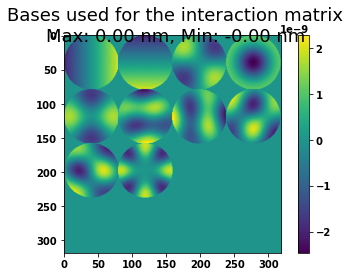

In [2]:
dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
displayMap(tel.OPD)

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


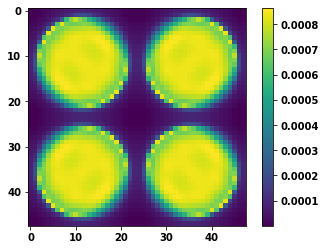

In [3]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 0, 'KL mode')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

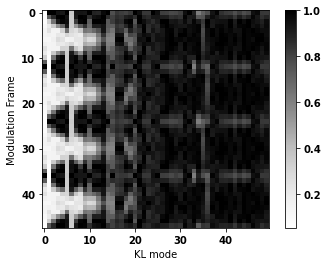

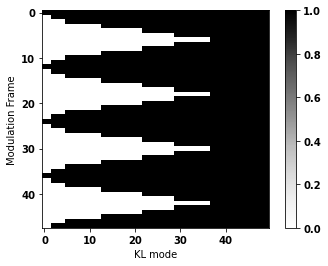

In [4]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = 50
stroke = 1*1e-9

i_cube = np.zeros((wfs.nTheta, np.sum(wfs.validSignal), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]

# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):
    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, wfs.validSignal]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, wfs.validSignal]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)

plt.figure()

weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    weighting_cube[:,i] = (np.sqrt(np.sum(i_cube[:, :, i]**2, axis=1)))
    #weighting_cube[:,i] = weighting_cube[:,i] - np.min(weighting_cube[:,i])
    weighting_cube[:,i] = weighting_cube[:,i]  / np.max(weighting_cube[:,i])

plt.figure()
im = plt.imshow(weighting_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")
plt.figure()
# binary_weight_cube = np.copy(weighting_cube)
# threshold = 0.5
# binary_weight_cube[weighting_cube < threshold] = 0
# binary_weight_cube[weighting_cube >= threshold] = 1

framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                      3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
binary_weight_cube = np.ones((wfs.nTheta, nModes))
for f in range(len(framesRemPerFace)):
    idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
    binary_weight_cube[idx, f] = 0


im = plt.imshow(binary_weight_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

In [5]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = 50
stroke = 1*1e-9


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube[:, wfs.validSignal]
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube[:, wfs.validSignal]
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.frame[wfs.validSignal]
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.frame[wfs.validSignal]
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)


        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])


I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 1.0, 'Identity of TR reconstructor. RMS err = 7.704385759912791e-17')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


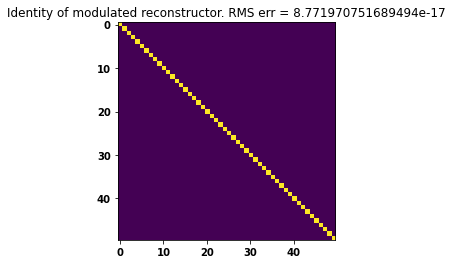

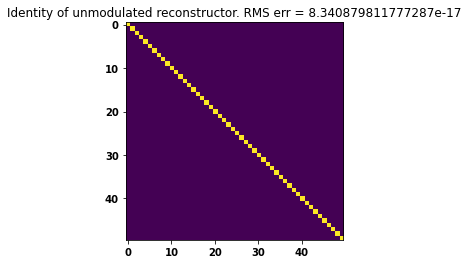

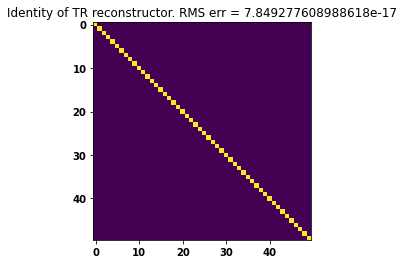

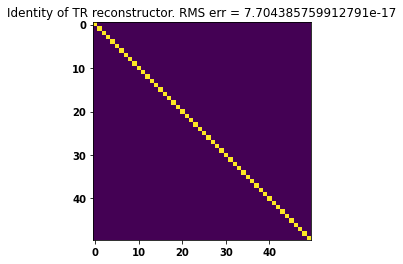

In [6]:
plt.figure()
plt.imshow(I_mat_modulated_inv@I_mat_modulated)
diag_modulated_err_rms = np.sqrt(np.mean((I_mat_modulated_inv@I_mat_modulated - np.identity(nModes))**2))
plt.title(f"Identity of modulated reconstructor. RMS err = {diag_modulated_err_rms}")
plt.figure()
plt.imshow(I_mat_unmodulated_inv@I_mat_unmodulated)
diag_unmodulated_err_rms = np.sqrt(np.mean((I_mat_unmodulated_inv@I_mat_unmodulated - np.identity(nModes))**2))
plt.title(f"Identity of unmodulated reconstructor. RMS err = {diag_unmodulated_err_rms}")
plt.figure()
plt.imshow(I_mat_weighted_inv@I_mat_weighted)
diag_weighted_err_rms = np.sqrt(np.mean((I_mat_weighted_inv@I_mat_weighted - np.identity(nModes))**2))
plt.title(f"Identity of TR reconstructor. RMS err = {diag_weighted_err_rms}")
plt.figure()
plt.imshow(I_mat_binary_inv@I_mat_binary)
diag_binary_err_rms = np.sqrt(np.mean((I_mat_binary_inv@I_mat_binary - np.identity(nModes))**2))
plt.title(f"Identity of TR reconstructor. RMS err = {diag_binary_err_rms}")

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 1.0, 'Linearity with no noise for KL 10')

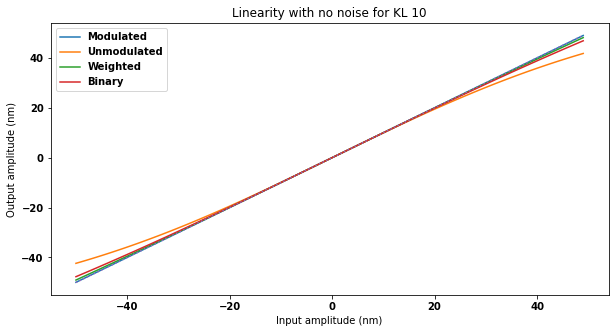

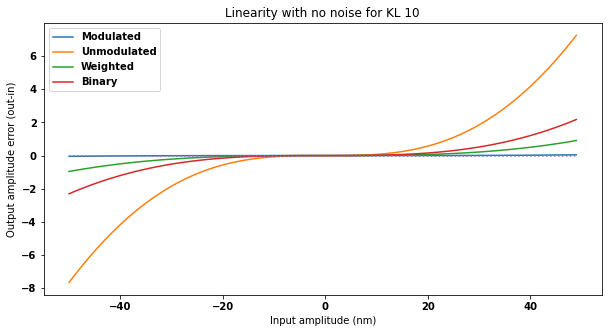

In [7]:
wfs.cam.photonNoise = False
amps = np.arange(-50, 50, 1)
modulated_resp = np.zeros((len(amps)))
unmodulated_resp = np.zeros((len(amps)))
weighted_resp = np.zeros((len(amps)))
binary_resp = np.zeros((len(amps)))

modulated_resp_err = np.zeros((len(amps)))
unmodulated_resp_err = np.zeros((len(amps)))
weighted_resp_err = np.zeros((len(amps)))
binary_resp_err = np.zeros((len(amps)))
KL_mode_to_use = 10

wfs.modulation = param['modulation']
for i in range(len(amps)):
    dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

    tel * dm * wfs

    signal = wfs.cam.cube[:, wfs.validSignal]

    normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                    np.sum(ref_cube, axis=0)/np.sum(ref_cube)
    weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                  np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])

    binary_signal = np.sum(signal*binary_weight_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*binary_weight_cube[:, np.newaxis, KL_mode_to_use]) - \
                  np.sum(ref_cube*binary_weight_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*binary_weight_cube[:, np.newaxis, KL_mode_to_use])

    modulated_resp[i] =  (I_mat_modulated_inv@normal_signal)[KL_mode_to_use] / 1e-9
    weighted_resp[i] = (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9
    binary_resp[i] = (I_mat_binary_inv@binary_signal)[KL_mode_to_use] / 1e-9
    modulated_resp_err[i] =  amps[i] - (I_mat_modulated_inv@normal_signal)[KL_mode_to_use] / 1e-9
    weighted_resp_err[i] = amps[i] - (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9
    binary_resp_err[i] = amps[i] - (I_mat_binary_inv@binary_signal)[KL_mode_to_use] / 1e-9


wfs.modulation = 0
dm.coefs = 0
ngs * tel * dm * wfs
ref_frame = wfs.cam.frame[wfs.validSignal]
for i in range(len(amps)):
    dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

    tel * dm * wfs

    signal = wfs.cam.frame[wfs.validSignal]

    unmodulated_signal = signal/np.sum(signal) - ref_frame/np.sum(ref_cube)


    unmodulated_resp[i] =  (I_mat_unmodulated_inv@unmodulated_signal)[KL_mode_to_use] / 1e-9
    unmodulated_resp_err[i] =  amps[i] - (I_mat_unmodulated_inv@unmodulated_signal)[KL_mode_to_use] / 1e-9


plt.figure(figsize=(10,5))
plt.plot(amps, modulated_resp, label="Modulated")
plt.plot(amps, unmodulated_resp, label="Unmodulated")
plt.plot(amps, weighted_resp, label="Weighted")
plt.plot(amps, binary_resp, label="Binary")
plt.plot(amps, amps, ':')
plt.legend()
plt.xlabel("Input amplitude (nm)")
plt.ylabel("Output amplitude (nm)")
plt.title(f"Linearity with no noise for KL {KL_mode_to_use}")


plt.figure(figsize=(10,5))
plt.plot(amps, modulated_resp_err, label="Modulated")
plt.plot(amps, unmodulated_resp_err, label="Unmodulated")
plt.plot(amps, weighted_resp_err, label="Weighted")
plt.plot(amps, binary_resp_err, label="Binary")
plt.plot(amps, amps*0, ':')
plt.legend()
plt.xlabel("Input amplitude (nm)")
plt.ylabel("Output amplitude error (out-in)")
plt.title(f"Linearity with no noise for KL {KL_mode_to_use}")

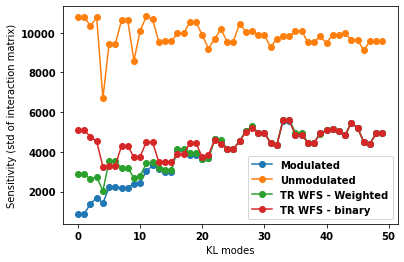

In [8]:
plt.figure()
plt.plot(np.std(I_mat_modulated, axis=0), marker="o",label="Modulated")
plt.plot(np.std(I_mat_unmodulated, axis=0), marker="o",label="Unmodulated")
plt.plot(np.std(I_mat_weighted, axis=0), marker="o", label="TR WFS - Weighted")
plt.plot(np.std(I_mat_binary, axis=0), marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()

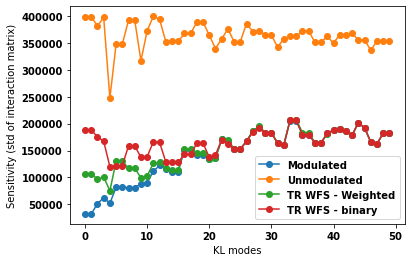

In [9]:
plt.figure()
tmp1 = I_mat_modulated.T@I_mat_modulated
tmp2 = np.diag(tmp1)
tmp3 = np.sqrt(tmp2)
plt.plot(np.sqrt(np.diag(I_mat_modulated.T@I_mat_modulated)), marker="o",label="Modulated")
plt.plot(np.sqrt(np.diag(I_mat_unmodulated.T@I_mat_unmodulated)), marker="o",label="Unmodulated")
plt.plot(np.sqrt(np.diag(I_mat_weighted.T@I_mat_weighted)), marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(np.diag(I_mat_binary.T@I_mat_binary)), marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()

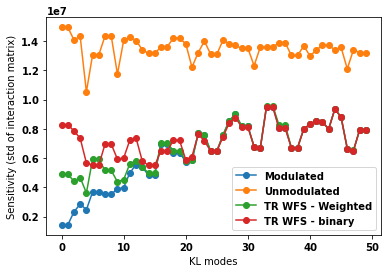

In [10]:

reference = np.tile(wfs.referenceSignal, (50,1)).T
plt.figure()
plt.plot(np.sqrt(np.sum((I_mat_modulated / np.sqrt(reference))**2, axis=0)), marker="o",label="Modulated")
plt.plot(np.sqrt(np.sum((I_mat_unmodulated / np.sqrt(reference))**2, axis=0)), marker="o",label="Unmodulated")
plt.plot(np.sqrt(np.sum((I_mat_weighted / np.sqrt(reference))**2, axis=0)), marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(np.sum((I_mat_binary / np.sqrt(reference))**2, axis=0)), marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()

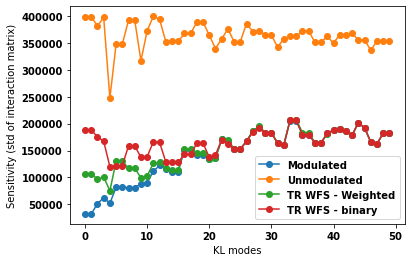

In [11]:

plt.figure()
plt.plot(np.sqrt(np.sum((I_mat_modulated)**2, axis=0)), marker="o",label="Modulated")
plt.plot(np.sqrt(np.sum((I_mat_unmodulated )**2, axis=0)), marker="o",label="Unmodulated")
plt.plot(np.sqrt(np.sum((I_mat_weighted )**2, axis=0)), marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(np.sum((I_mat_binary )**2, axis=0)), marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 1.0, 'Binary')

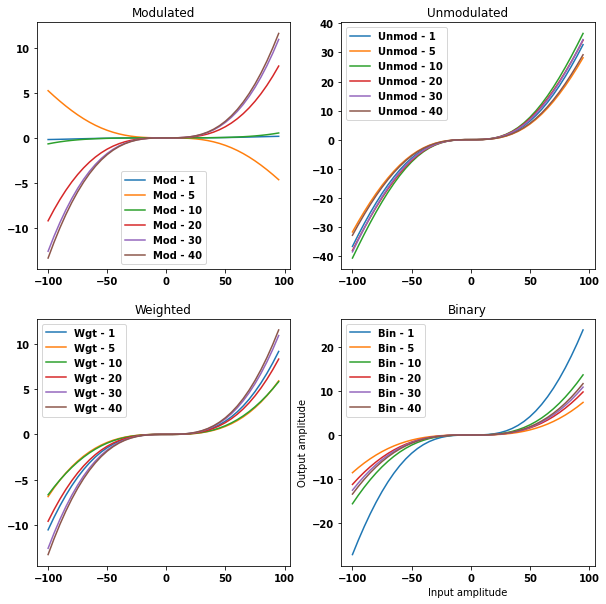

In [12]:
# Linearite des systemes
wfs.cam.photonNoise = False
amps = np.arange(-100, 100, 5)
modulated_err_2 = np.zeros((len(amps)))
unmodulated_err_2 = np.zeros((len(amps)))
weighted_err_2 = np.zeros((len(amps)))
binary_err_2 = np.zeros((len(amps)))
KL_mode_to_use = 40

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))
wfs.modulation = param['modulation']
dm.coefs = 0
ngs * tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]
for KL_mode_to_use in [1,5,10, 20, 30, 40]:
    for i in range(len(amps)):
        dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

        tel * dm * wfs

        signal = wfs.cam.cube[:, wfs.validSignal]

        normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                        np.sum(ref_cube, axis=0)/np.sum(ref_cube)
        weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                          np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])

        binary_signal = np.sum(signal*binary_weight_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*binary_weight_cube[:, np.newaxis, KL_mode_to_use]) - \
                  np.sum(ref_cube*binary_weight_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*binary_weight_cube[:, np.newaxis, KL_mode_to_use])


        modulated_err_2[i] =  amps[i]  - (I_mat_modulated_inv@normal_signal)[KL_mode_to_use] / 1e-9
        weighted_err_2[i] = amps[i]  - (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9
        binary_err_2[i] = amps[i]  - (I_mat_binary_inv@binary_signal)[KL_mode_to_use] / 1e-9
    ax1.plot(amps, modulated_err_2, label=f"Mod - {KL_mode_to_use}")
    ax3.plot(amps, weighted_err_2, label=f"Wgt - {KL_mode_to_use}")
    ax4.plot(amps, binary_err_2, label=f"Bin - {KL_mode_to_use}")


wfs.modulation = 0
dm.coefs = 0
ngs * tel * dm * wfs
ref_frame = wfs.cam.frame[wfs.validSignal]
for KL_mode_to_use in [1,5,10, 20, 30, 40]:
    for i in range(len(amps)):
        dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

        tel * dm * wfs

        signal = wfs.cam.frame[wfs.validSignal]

        unmodulated_signal = signal/np.sum(signal) - ref_frame/np.sum(ref_cube)

        unmodulated_err_2[i] =  amps[i] - (I_mat_unmodulated_inv@unmodulated_signal)[KL_mode_to_use] / 1e-9
    ax2.plot(amps, unmodulated_err_2, label=f"Unmod - {KL_mode_to_use}")

ax1.legend()
plt.xlabel("Input amplitude")
plt.ylabel("Output amplitude")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_title(f"Modulated")
ax2.set_title(f"Unmodulated")
ax3.set_title(f"Weighted")
ax4.set_title(f"Binary")

In [13]:
tel - atm
wfs.cam.photonNoise = False
nModes = 50
stroke = 1*1e-9


def getSensitivityModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = int(wfs.cam.cube[:, wfs.validSignal])

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = int(wfs.cam.cube[:, wfs.validSignal])
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = int(wfs.cam.cube[:, wfs.validSignal])
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        imat[:,m] = imat[:,m] / np.sqrt(np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m]))
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getSensitivityUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = int(wfs.cam.frame[wfs.validSignal])

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = int(wfs.cam.frame[wfs.validSignal])
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = int(wfs.cam.frame[wfs.validSignal])
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)



        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)

        imat[:,m] = imat[:,m] / np.sqrt(ref_frame/np.sum(ref_frame))
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

s_y_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
s_y_unmodulated = getInterationMatrixUnmodulated()
s_y_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
s_y_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


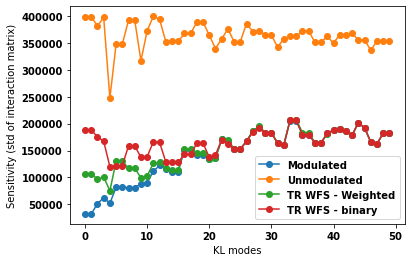

In [14]:
plt.figure()
plt.plot(np.sqrt(np.sum((s_y_modulated)**2, axis=0)), marker="o",label="Modulated")
plt.plot(np.sqrt(np.sum((s_y_unmodulated )**2, axis=0)), marker="o",label="Unmodulated")
plt.plot(np.sqrt(np.sum((s_y_weighted )**2, axis=0)), marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(np.sum((s_y_binary )**2, axis=0)), marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()